# Effects of Clioquinol on yeast
Ryan Byrne

In [7]:
%load_ext autoreload
%autoreload 2
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes
bmes.pipinstall('Bio','biopython')
bmes.pipinstall('GEOparse')
bmes.pipinstall('pandasql')
bmes.pipinstall('statsmodels')


import GEOparse
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download GSE File

In [2]:
#File to download
filegeo = "GSE17257"
arr = os.listdir(bmes.tempdir())

#Check if file exists in tempdir with file name
flag = 1
for file in arr:
    result = file.find(filegeo)
    if (result == 0):
        flag = 0

#If file does not exist, download file
if (flag == 1):
    gse = GEOparse.get_GEO(geo=filegeo, destdir=bmes.tempdir());
#If file exists 
else:
    gse = GEOparse.get_GEO(filepath=bmes.tempdir() + '/' + filegeo + '_family.soft.gz')

17-Apr-2022 20:02:55 INFO GEOparse - Parsing C:/Users/user/AppData/Local/Temp/bmes/GSE17257_family.soft.gz: 
17-Apr-2022 20:02:55 DEBUG GEOparse - DATABASE: GeoMiame
17-Apr-2022 20:02:55 DEBUG GEOparse - SERIES: GSE17257
17-Apr-2022 20:02:55 DEBUG GEOparse - PLATFORM: GPL2529
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432203
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432204
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432205
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432206
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432207
17-Apr-2022 20:02:56 DEBUG GEOparse - SAMPLE: GSM432208


# Format Data from file in Table

In [3]:
gsedata = None
names = []
#Store data into table
for gsmid in gse.gsms.keys():
    #store gsmid names in list
    names.append(gsmid)
    gsmdata = gse.gsms[gsmid].table.rename(columns={'VALUE':gsmid});
    #remove Unneed columns
    if "ABS_CALL" in gsmdata:
        del gsmdata["ABS_CALL"]
    if "DETECTION P-VALUE" in gsmdata:
        del gsmdata["DETECTION P-VALUE"]
    #Append data to gsedata
    if gsedata is None: gsedata=gsmdata;
    else:
        assert(gsedata['ID_REF'].equals(gsmdata['ID_REF'])) #just make sure that the same probes are listed in the same order.
        gsedata = pd.concat([gsedata,gsmdata[gsmid]],axis=1);

gsedata = gsedata.set_index('ID_REF')
gsedata.head()

,GSM432203,GSM432204,GSM432205,GSM432206,GSM432207,GSM432208
ID_REF,,,,,,
AFFX-BioB-5_at,212.502,414.776,383.139,351.550,893.897,476.621
AFFX-BioB-M_at,237.005,469.306,473.493,407.539,1056.330,511.049
AFFX-BioB-3_at,216.365,463.476,466.453,385.204,1055.990,493.247
AFFX-BioC-5_at,336.581,731.790,716.848,647.458,1672.720,837.061
AFFX-BioC-3_at,575.513,1099.120,1117.000,1003.060,2141.200,1275.160


# Show a hierarchical clustering of samples. (Just a hierarchical clustering (ie a dendrogram) of samples, not a heatmap of expression values.)

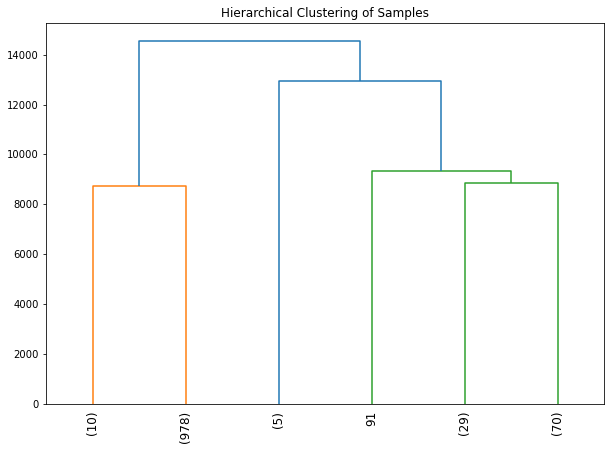

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

#variances of the data
vars = gsedata.var(axis=1) 

import numpy
import math

#Remove 90% of genes
sortedvars = numpy.sort( vars.values )
minvar = sortedvars[ math.floor(sortedvars.size*0.9) ]
d2 = gsedata.drop( gsedata[vars<minvar].index, axis=0)

#Create phylogenetic tree
phy = linkage(d2, 'average')

#plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    phy,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False# to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering of Samples')
plt.show()


# Show a clustergram (heatmap, combined with clustering of samples and clustering of genes) of expression values.

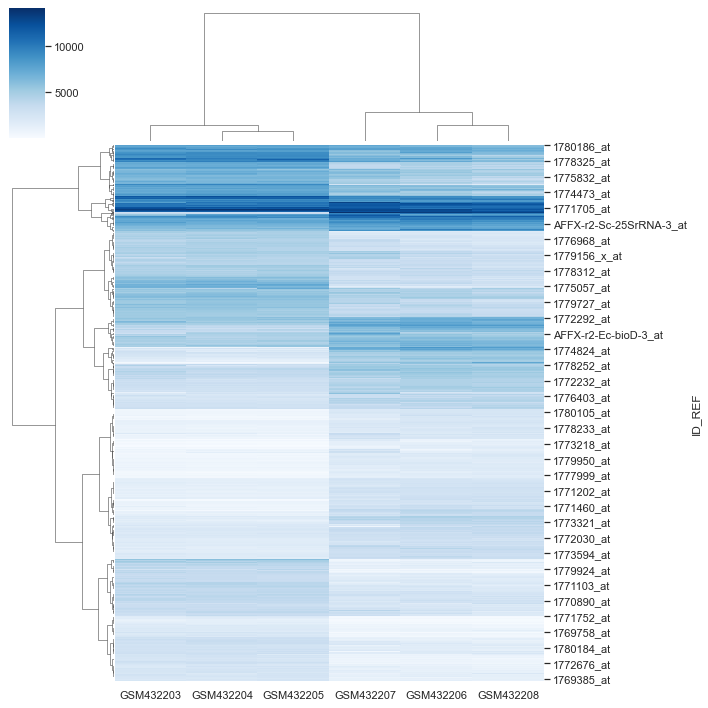

In [23]:
import seaborn

#Create clustergram
seaborn.set(style='darkgrid')
clust = seaborn.clustermap(d2, metric="euclidean", method="ward", cmap="Blues")

# Report the top 10 most different genes between the Clioquinol and control groups.

In [6]:
from scipy import stats
from statsmodels.stats import multitest
from pathlib import Path 

#Split data into control and clioquinol groups
control_group = gsedata[["GSM432203","GSM432204", "GSM432205"]]
cq_group = gsedata[["GSM432206","GSM432207", "GSM432208"]]

#Calcuate the fdr corrected p-value between control and clioquinol groups
tresult = stats.ttest_ind(control_group.transpose(), cq_group.transpose())
pvals = list(tresult.pvalue)
fdr_pval_result = multitest.fdrcorrection(pvals)
fdr_pvals = fdr_pval_result[1][:]

#Calculate the log2 fold change between control and clioquinol groups
log2fc = np.log2(cq_group.mean(axis=1) / control_group.mean(axis=1));

#Build a dataframe for storing only significant genes
different_genes = pd.DataFrame()
different_genes.insert(loc=0,
          column='ID_REF',
          value=gsedata.index)
different_genes.insert(loc=1,
          column='fold change',
          value=log2fc.values)
different_genes.insert(loc=2,
          column='p-value',
          value=fdr_pvals)

#Filter genes that have a p-value less than 0.01 and a log2 fold change of 1.5
most_different_genes = different_genes.loc[(different_genes['p-value'] <0.01) & (np.absolute(different_genes['fold change']) > math.log2(1.5))]

#Report the top 10 different genes
print(most_different_genes.sort_values(by=['p-value'])[0:10])

#File path for output file
filepath = Path('C:/Users/user/Dropbox/bmes543.RyanByrne.rpb53/ma/cqSigGenes.csv')  

#Export significant genes to csv file
#most_different_genes.to_csv(filepath, index=False)

          ID_REF  fold change   p-value
2163  1777972_at     2.777923  0.000141
5648  1777371_at     2.175741  0.000141
3827  1777623_at     1.811861  0.000150
4976  1771341_at     4.488675  0.000150
291   1776525_at    -1.538356  0.000227
3758  1771069_at    -2.053845  0.000227
3978  1777661_at     1.385341  0.000277
5450  1771389_at     1.474276  0.000344
5846  1773288_at    -1.787009  0.000363
2842  1774545_at    -1.451662  0.000422


# Report the functional annotations (GO Biological Processes and KEGG Pathways) that are significantly different between the two groups.

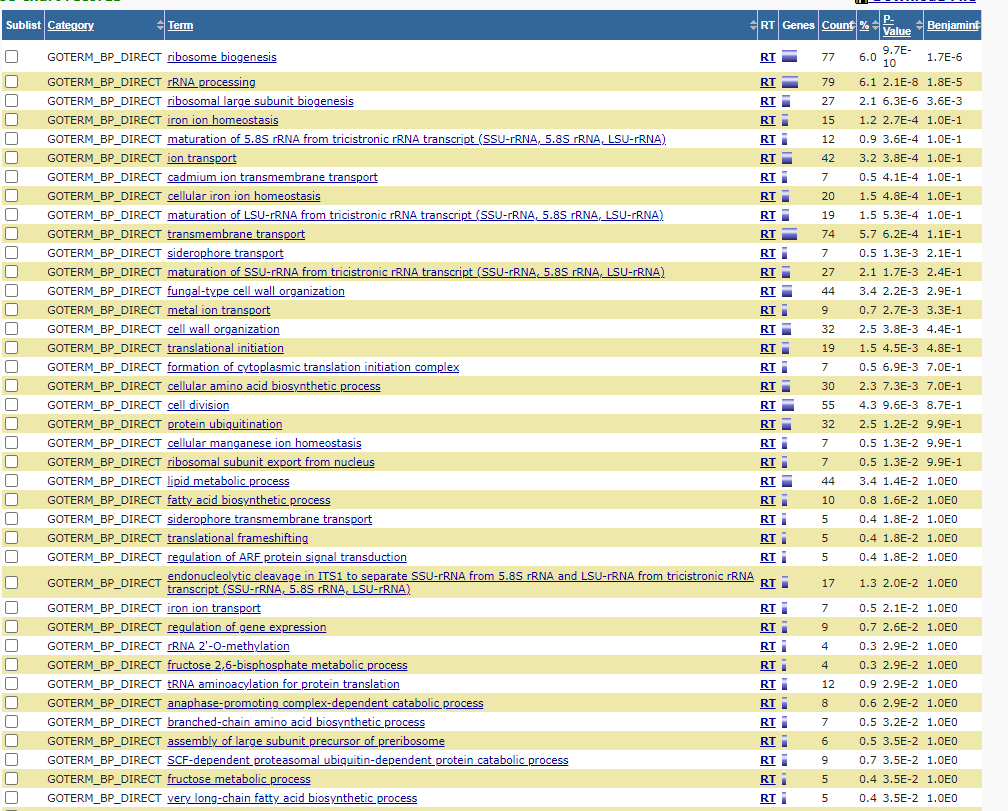

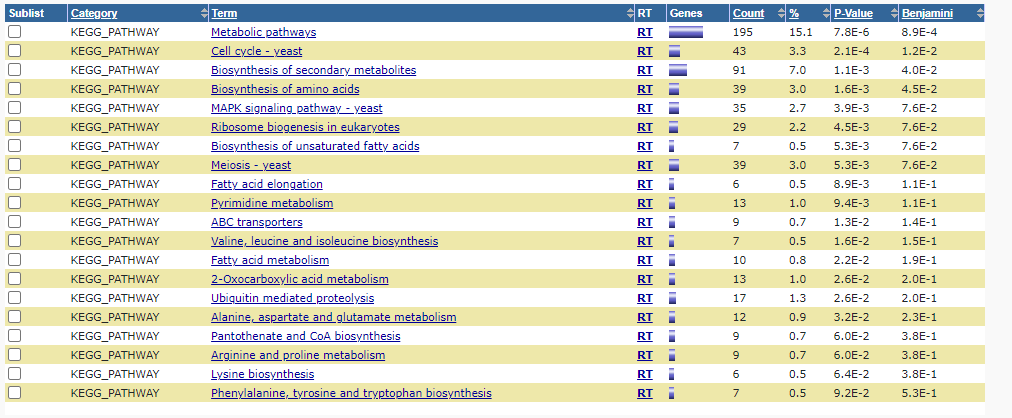

# Discuss whether your results align with the findings reported in the paper.

The KEGG pathway results showed that Clioquinol modulated genes involved in metabolic pathways, cell signaling pathways, biosynthesis, and membrane transport. While the paper did not report finding that Clioquinol affect metabolic, cell signaling, and biosynthesis pathways, it did go into detail on how Clioquinol affects transport. The ABC transporter family includes proteins to transport metals across the membrane. Overall, most of the results did not align with the paper, but its possible the modulation of the ABC transporter aligns with the paper's results.

In [8]:
!export PATH=/Library/TeX/texbin:$PATH

'export' is not recognized as an internal or external command,
operable program or batch file.
